## Time to get your hands dirty.  The transient Universe

Time-domain astronomy is one of the new frontiers. Example of transient phenomena include:

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
#import corner

import dynesty

In [384]:
def burst_model(params, time):
    b, A, t0, alpha = params

    y = A * np.exp( - alpha * (time - t0) )
    y[time < t0] = 0
    return y + b

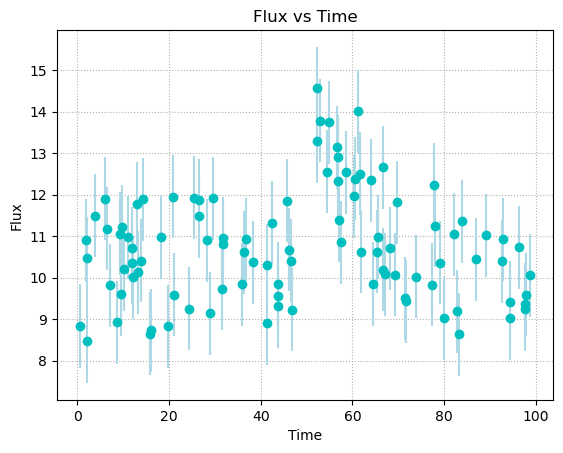

In [10]:
data = np.load("transient.npy", allow_pickle=True)
time, flux_obs, err_flux = data[:, 0], data[:, 1], data[:, 2]

plt.errorbar(time, flux_obs, err_flux, c='c', ecolor='lightblue', fmt = "o")

plt.title("Flux vs Time")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid(linestyle = ":")

# simple eyeballing of the INITIAL GUESSES (not prior) 
#myt=np.linspace(0,100,100)
#mym =burst_model([10,5,50,1e-1], myt)
#plt.plot(myt,mym)

plt.show()

In [386]:
def Log_Likelihood( params, time, flux_obs, err_flux):
    flux_model = burst_model(params, time)

    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux_obs - flux_model) / err_flux)**2)


def Log_Prior(params):
    b, A, t0, alpha = params
    
    if b < 0 or b > 50 or A < 0 or A > 50 or t0 < 0 or t0 > 100 or alpha < 1e-5 or alpha > 1e5: 
        return -np.inf
    else:
        return -np.log(50 * 50 * 100 * np.log(1e5/1e-5) * alpha) 


def Log_Posterior(params, time, flux_obs, err_flux):
    logPrior = Log_Prior(params)
    
    if np.isfinite(logPrior):
        return logPrior + Log_Likelihood(params, time, flux_obs, err_flux)
    else:
        return logPrior

In [387]:
n_dim = 4
n_walkers = 10
n_steps = 10000 

np.random.seed(0)
starting_guesses = np.array([10,5,50,1e-1]) + 1e-2 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, Log_Posterior, args=[ time, flux_obs, err_flux])
sampler.run_mcmc(starting_guesses, n_steps)

print("Done") 

Done


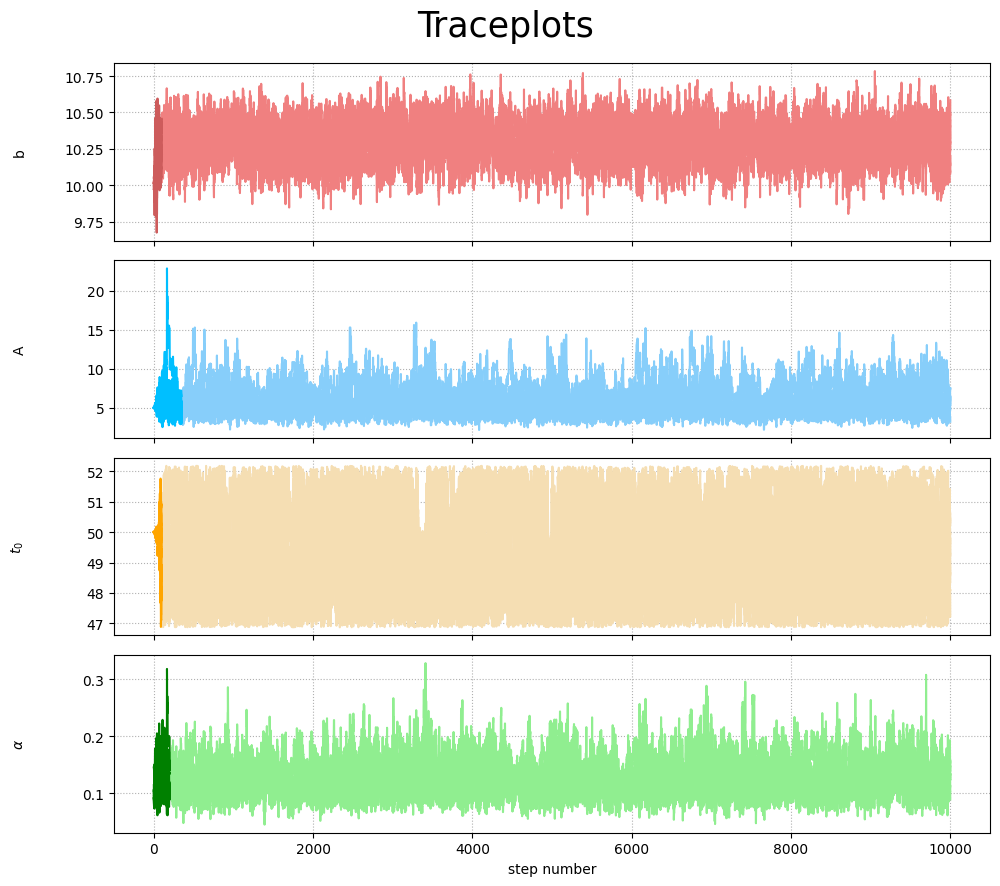

In [388]:
samples = sampler.get_chain() # sampler.chain is of shape (nwalkers, nsteps, ndim)

labels = ["b", "A", r"$t_0$", r"$\alpha$"]
steps = np.linspace(0, n_steps, n_steps)
colors = ["lightcoral", "lightskyblue", "wheat","lightgreen" ]
dark_colors = ["indianred", "deepskyblue", "orange", "green"]

burns = [100, 350, 100, 200]

fig, axes = plt.subplots(4, figsize=(10, 9), sharex=True)
fig.suptitle("Traceplots", fontsize=25)

for i in range(0, n_dim):
    ax = axes[i]
    burn = burns[i]
    color = colors[i]
    dark_color = dark_colors[i]

    ax.plot(steps[burn:],samples[burn:, :, i], c=color)
    ax.plot(steps[:burn], samples[:burn, :, i], c=dark_color, label="Burn-in")

    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xlim(0, 1000)
    ax.grid(linestyle=":")


axes[-1].set_xlabel("step number")

plt.tight_layout()
plt.subplots_adjust(top=0.92)  
plt.show()


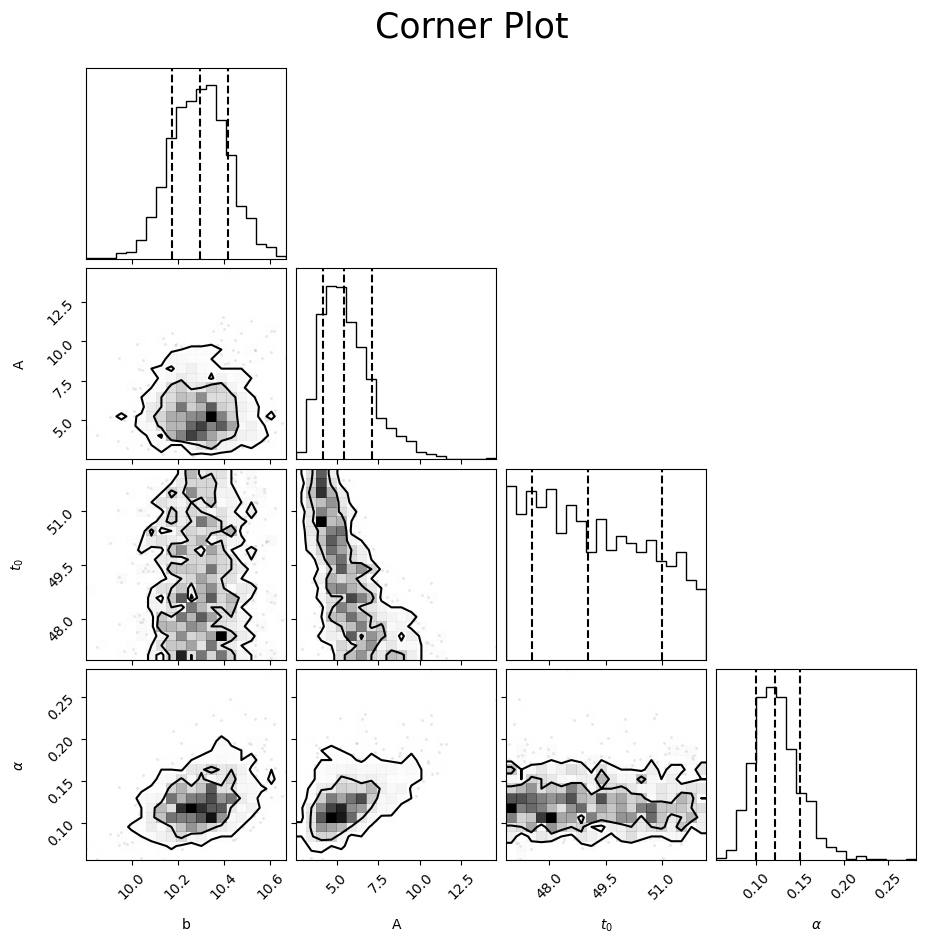

In [393]:
taus = 

burn = np.max(burns)
thin = int(np.max(taus)) + 1

emcee_traces = sampler.get_chain(discard=burn, thin=thin, flat=True)
fig = corner.corner(emcee_traces, labels=labels, show_titles=False, title_args={"fontsize": 12},
                    quantiles=[0.16, 0.5, 0.84],  
                    levels=[0.682, 0.95])
                  
fig.suptitle("Corner Plot", fontsize = 25)
plt.subplots_adjust(top=0.92)  
plt.show()

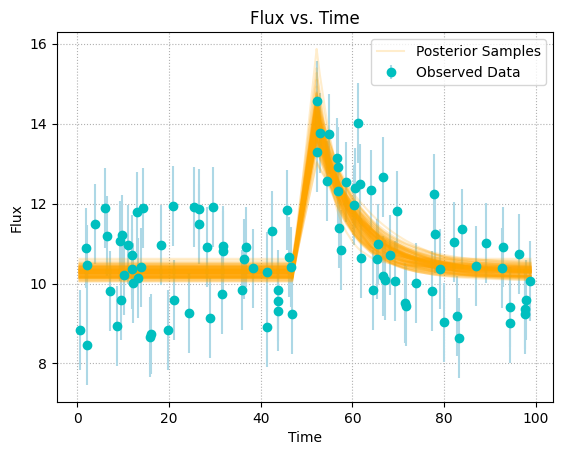

In [391]:
idx = np.random.choice(len(emcee_traces), size=100, replace=False)
random_samples = emcee_traces[idx, :]

plt.errorbar(time, flux_obs, err_flux, c='c', ecolor='lightblue', fmt = "o", label="Observed Data")

for i, params in enumerate(random_samples):
    y_model = burst_model(params, time)
    label = "Posterior Samples" if i == 0 else None
    plt.plot(time, y_model, color='orange', alpha=0.2, label=label)

plt.title("Flux vs. Time")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid(linestyle=":")
plt.legend()
plt.show()

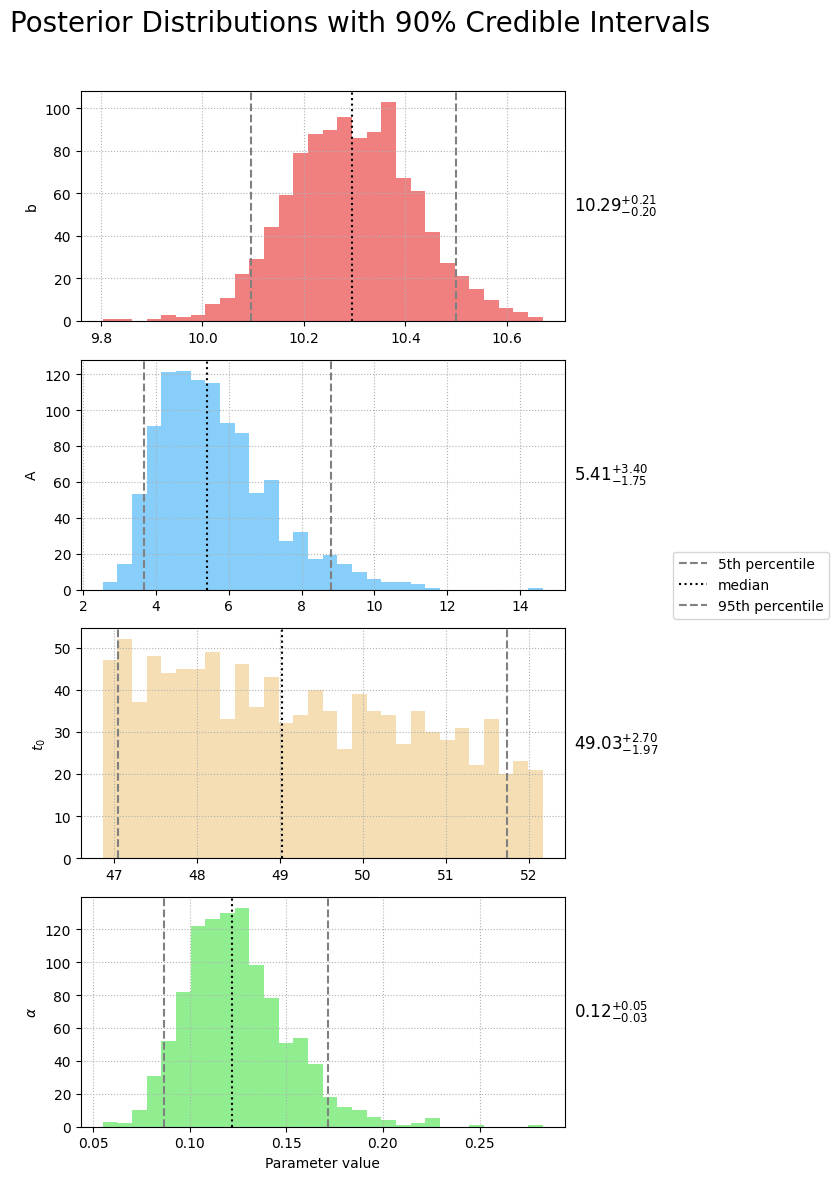

In [411]:
quantiles = [5, 50, 95]

fig, axes = plt.subplots(4, figsize=(7, 12), sharex=False)
fig.suptitle("Posterior Distributions with 90% Credible Intervals", fontsize=20)

for i, name in enumerate(labels):    
    ax = axes[i]
    params = emcee_traces[:, i]
    color = colors[i]
    ax.hist(params, bins=30, color=color)

    q = np.percentile(params, quantiles)
    median = q[1]
    lower = median - q[0]
    upper = q[2] - median

    ax.axvline(q[0], color='gray', linestyle='--', label='5th percentile' if i == 0 else "")
    ax.axvline(q[1], color='black', linestyle=':', label='median' if i == 0 else "")
    ax.axvline(q[2], color='gray', linestyle='--', label='95th percentile' if i == 0 else "")

    ax.set_ylabel(name)
    ax.grid(linestyle=':')

    textstr = f"${median:.2f}^{{+{upper:.2f}}}_{{-{lower:.2f}}}$"
    ax.text(1.02, 0.5, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='center')

axes[-1].set_xlabel("Parameter value")

# Legenda fuori dal grafico
handles, labels_leg = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_leg, loc='center right', bbox_to_anchor=(1.18, 0.5))

plt.tight_layout(rect=[0, 0, 0.95, 0.96]) 
plt.show()


In [11]:
def prior_transform(u):
    out = np.zeros(len(u))
    out[0:2] = 50 * u[0:2]
    out[2] = 100 * u[2]
    out[3] = 5 * (2 * u[3] - 1)
    return out

def burst_model(params, time):
    b, A, t0, logalpha = params
    alpha = np.exp(logalpha)

    y = A * np.exp( - alpha * (time - t0) )
    y[time < t0] = 0
    return y + b

def Log_Likelihood(params):
    flux_model = burst_model(params, time)

    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux_obs - flux_model) / err_flux)**2) + np.sum(1 / (err_flux * np.sqrt(2 * np.pi)))

In [12]:
ndim = 4

# "Static" nested sampling.
sampler = dynesty.NestedSampler(Log_Likelihood, prior_transform, ndim)
sampler.run_nested()
sresults = sampler.results

/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in exp
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in multiply
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in explstar:   -inf < -240.807 <    inf | logz: -249.187 +/-  0.120 | dlogz: 129.236 >  0.509]    
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in multiply
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in expglstar:   -inf < -176.873 <    inf | logz: -185.160 +/-  0.122 | dlogz: 64.476 >  0.509]
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflow encountered in multiply
  y = A * np.exp( - alpha * (time - t0) )
/tmp/ipykernel_3260/3667313812.py:12: RuntimeWarning: overflo

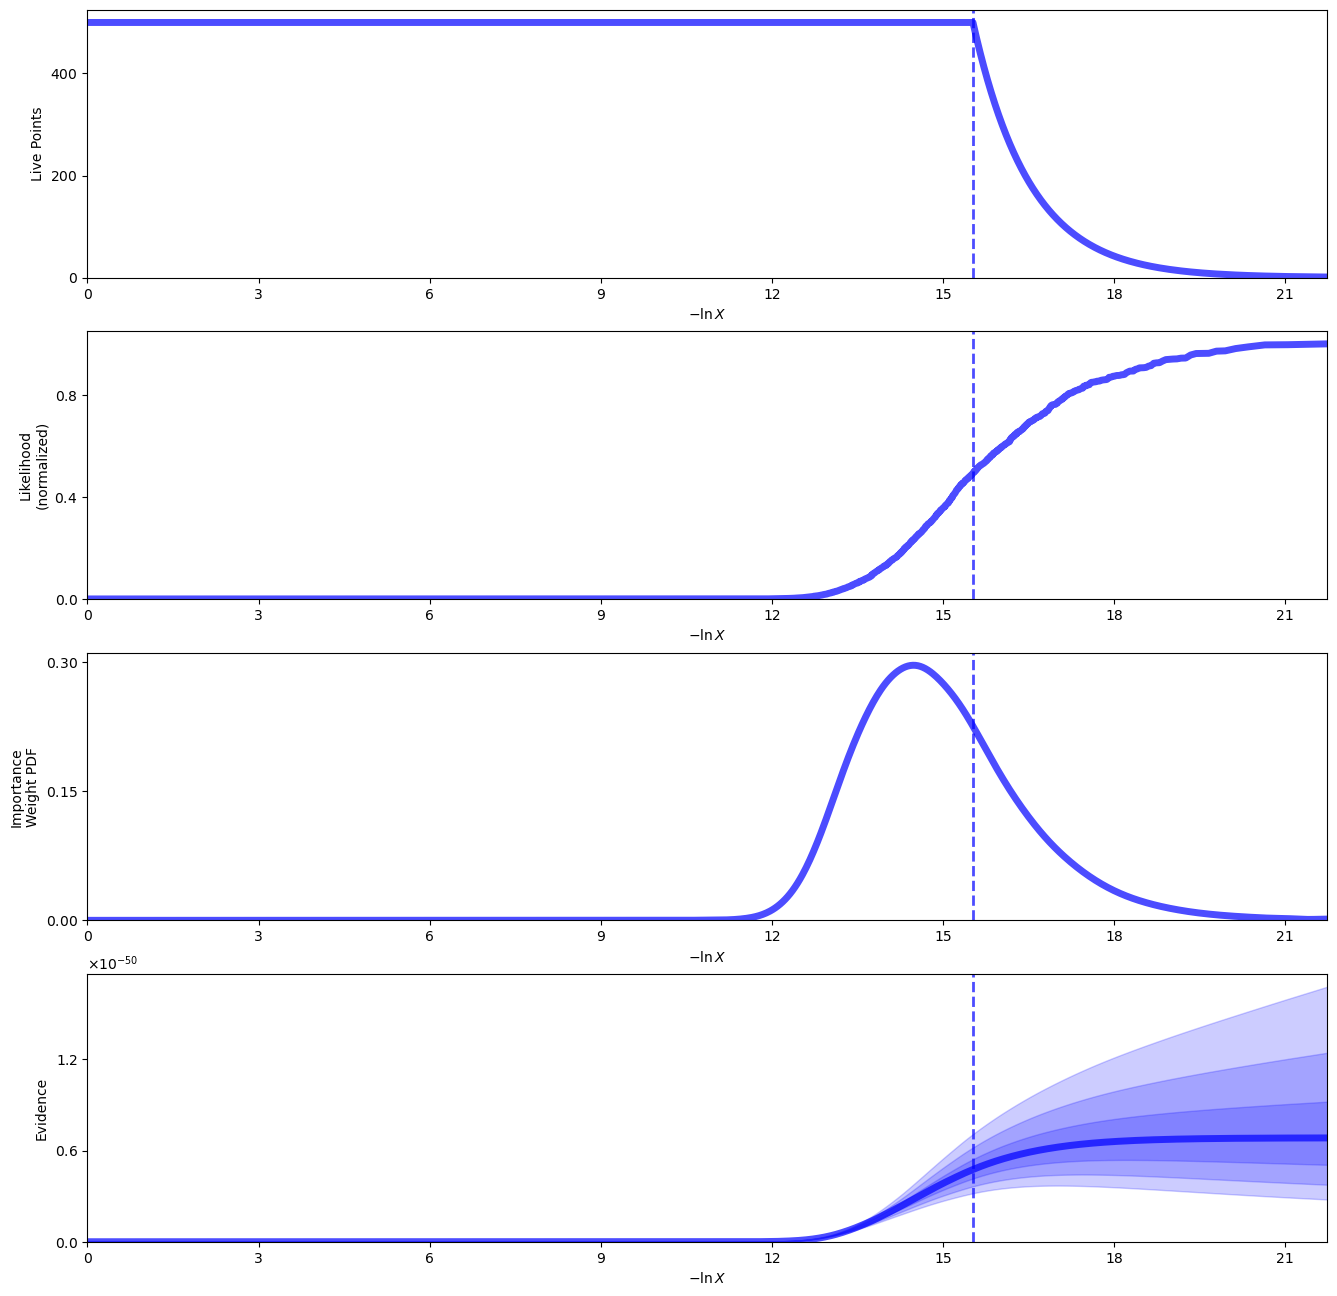

In [13]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

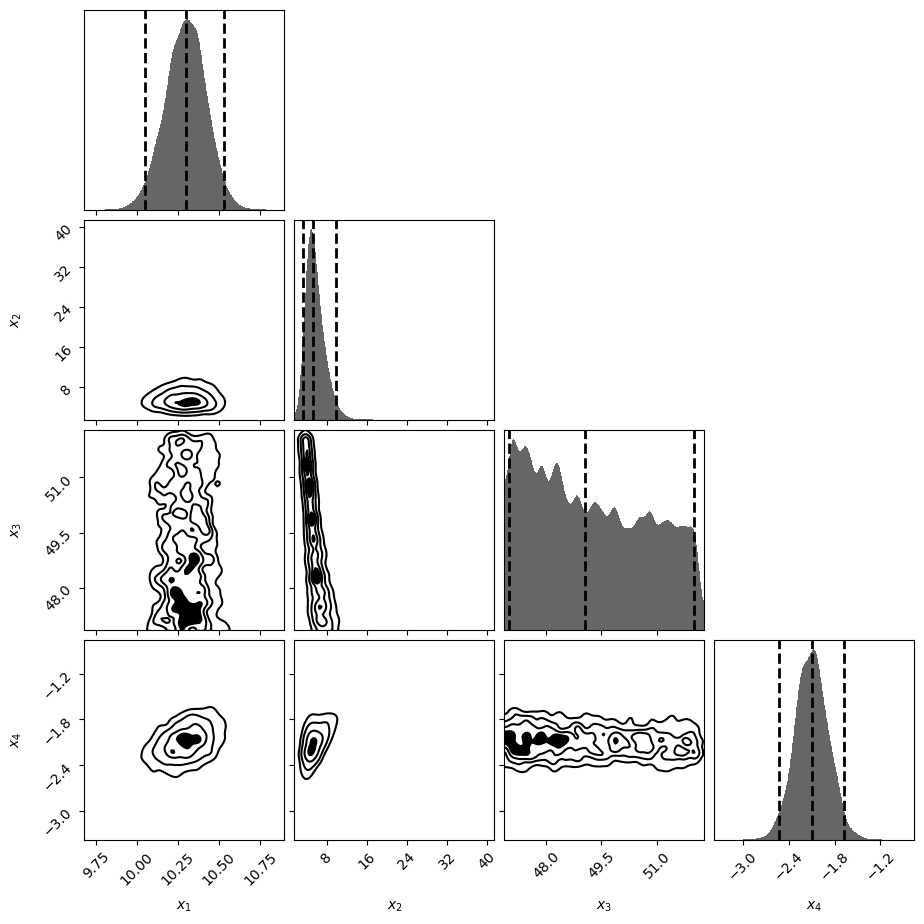

In [14]:
cfig, caxes = dyplot.cornerplot(sresults)